# Figure 9: 

Spatial distribution of (a) difference potential enstrophy tendency and contributions from (b) diabatic processes as well as advection by the (c) divergent flow and (d) the rotational flow at day 7.5. The black contours show the dynamical tropopause for the cyclone with CRH (solid) and without CRH (dashed) on the 326 K isentrope.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading derived dataset from part 02

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':1, 'rh':0.8}, # No radiation
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2km', 'radiation':1, 'rh':0.8}, # Only cloud radiation
             }

In [4]:
# loading datasets
# simulations
res = ['02_03']
#-------------------------------------
def load_simulations():
    ds_list = []
    for sim in list(res): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/pverrorgrowth/'
        # model output 'pv_icon' used for calculation
        fname1 = path+'pverror_diag_1x1_'+sim+'.nc'
        ds_var1 = xr.open_dataset(fname1)
        ds_var1.attrs['res'] = sim
        ds_list.append(ds_var1)      
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for 02_03


In [5]:
# Function to load diagnostics from part 01 to depict dynamical tropopause
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_1x1/'
        # datasets
        fname = path+"pvdiag_calc_1x1.nc" 
        ds_var = xr.open_dataset(fname).sel(lat=slice(10,80))
        ds_list.append(ds_var)
        del ds_var
    return ds_list
#----------------------------------
ds_list_pvdiag = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


## 3- Helper functions

In [6]:
# functions
# gradient (center difference)
def grad(var,delta,ax):
    df = np.gradient(var,delta,axis=ax)
    return(df)

# forward difference
def obs_fd(ds):
    if ds.attrs['res'] == 'native':
        obs_fd = np.zeros((ds.time.size,ds.ncells.size)) * np.nan
    else:
        obs_fd = np.zeros((ds.time.size,ds.lev.size,ds.lat.size,ds.lon.size)) * np.nan
    for t in range(len(ds.time)-1):
        obs_fd[t] = (ds.dpe[t+1] - ds.dpe[t])/3600 
    obs_fd[-1] =  (ds.dpe[-1] - ds.dpe[-2])/3600 
    if ds.attrs['res'] == 'native':
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','ncells'))
    else:
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','lev','lat','lon'))
    return(obs_fd_da)

# center difference
def obs_cd(ds):
    obs_cd_np = grad(ds.dpe,3600,0) # 1 hourly output
    if ds.attrs['res'] == 'native':
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','ncells'))
    else:    
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','lev','lat','lon'))
    return(obs_cd_np_da)

In [7]:
# common variables
lat  = ds_list[0].lat.values
lon  = ds_list[0].lon.values
time = ds_list[0].time
lev  = ds_list[0].lev

# PV error
p0 = ds_list_pvdiag[0].pv 
p1 = ds_list_pvdiag[1].pv

# deriving left hand side of the equation
ds_list[0]['ddtpv_ens'] = ds_list[0]['dpe'].diff(dim='time', label='upper')/3600
# or
ds_list[0]['ddtpv_ens_cd'] = obs_cd(ds_list[0])

## 4- Plot

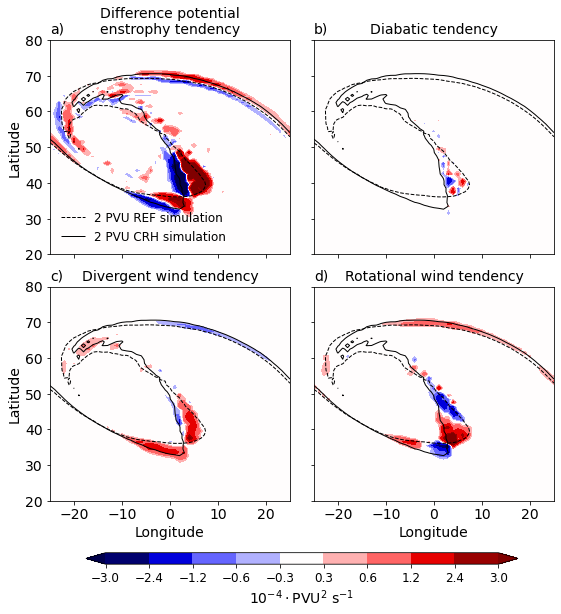

In [14]:
cbar_num_format = "%.0e"
clevels = np.array([-1,-0.8,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.8,1])*3
lon = lon-37.5
#---------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

i = 0
title = ['Difference potential\nenstrophy tendency','Diabatic tendency','Divergent wind tendency','Rotational wind tendency']

for ax in axes.flat:
    
    ax.tick_params(labelsize=14)
    ax.set_ylim([20, 80])
    ax.set_yticks(np.arange(20,90,10))

    if i == 0:
        
        im = ax.contourf(lon,lat,(ds_list[0]['ddtpv_ens_cd'].sel(lev=326,time=20210108.5))*(1e6**2)*1e4
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
        
        cs = ax.contour(lon,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        cs.collections[0].set_label('2 PVU REF simulation')
        cs = ax.contour(lon,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs.collections[0].set_label('2 PVU CRH simulation')
        ax.legend(loc='lower left',frameon=False,fontsize=12)
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=14)
        
        ax.set_title(title[0], fontsize=14)
        ax.set_xticklabels([]) 
        ax.set_ylabel('Latitude', fontsize=14)
        
    if i == 1:
        
        im = ax.contourf(lon,lat,(ds_list[0].ddtdia.sel(lev=326,time=20210108.5))*(1e6**2)*1e4
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
        
        cs = ax.contour(lon,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        ax.set_title(title[1], fontsize=14)
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=14)
        
    if i == 2:
        
        im = ax.contourf(lon,lat,(ds_list[0].ddtdiv.sel(lev=326,time=20210108.5))*(1e6**2)*1e4
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
        
        cs = ax.contour(lon,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        cs = ax.contour(lon,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.text(0.0, 1.03, 'c)', transform=ax.transAxes, 
            size=14)
        
        ax.set_title(title[2], fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        
    if i == 3:
        
        im = ax.contourf(lon,lat,(ds_list[0].ddtrot.sel(lev=326,time=20210108.5))*(1e6**2)*1e4 
             ,cmap=plt.get_cmap('seismic'),extend='both',levels=clevels)
    
        cs = ax.contour(lon,lat,(p1.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='solid')
        
        cs = ax.contour(lon,lat,(p0.sel(lev=326,time=20210108.5)),[2*1e-6],
                        linewidths=1,colors='k',linestyles='dashed')
        
        ax.set_title(title[3], fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, 'd)', transform=ax.transAxes, 
            size=14)
        
    i = i + 1      
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.15) 

cb_ax = fig.add_axes([0.15, -0.01, 0.6, 0.02]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im,cax=cb_ax,orientation='horizontal',shrink=0.95)
cbar.set_label(label='$10^{-4} \cdot $PVU$^2$ s$^{-1}$', size='14')#, weight='bold')
cbar.ax.tick_params(labelsize=12)    

plt.savefig('figure9.pdf', bbox_inches = 'tight')
#plt.savefig('figure9.png', bbox_inches = 'tight',dpi=100)